## SEIR model for spread of COVID-19

### Dr Wladimir Lyra, New Mexico State University (Department of Astronomy)

### Dr Jaber Belkhiria, University of California, Davis  (Center for Animal Disease Modeling and Surveillance, Department of Medicine & Epidemiology, School of Veterinary Medicine)

### Dr Jose Dias do Nascimento, Universidade Federal do Rio Grande do Norte (Department of Physics) 


We used a modified version of an 'SIR' type deterministic compartmental model to
trace COVID-19 epidemic evolution in an isolated population of N individuals.
We assumed that a population could be subdivided into the following compartments:
    Susceptible $S$: COV-19 naive individuals, 
    Exposed ($E$): Suceptible that have been exposed to infective individuals,
    Asymptomatic $A$: Infected and infective but showing mild or no symptoms
    Symptomatic $I$): Infected and infective but showing symptoms described in the litterature,
    Quarantined ($Q$): Symptomatic that are not infective, 
    Hospitalized ($H$) Symptomatic, not infective, who are being treated, 
    Removed ($R$) People removed from the epidemic dynamics by
    recovering or passing away.
    Finally, we add a confined $C$ compartment to model the effect of confinement of a proportion of susceptible. 

We assumed that the population is subcategories by age (range, 0-10, 10-20, 20-30, 30-40, 40-50, 50-60, 60-70, 70-80, and 80+ years old. ) and that rates should vary with age (REF).

Taking into consideration the 8 compartments and the 9 age groups, the model is described by a set of 81 coupled non-linear equations: 

\begin{eqnarray}
 \frac{dS_i}{dt} &=&-\lambda(t) S_i -\psi_i(t) S_i + \phi_i(t) C_i, \label{eq:dsdt}\\
 \frac{dC_i}{dt} &=&\psi_i(t) S_i - \phi_i(t) C_i, \label{eq:dcdt}\\  
\frac{dE_i}{dt} &=& \lambda(t) S_i -\sigma E_i, \label{eq:dedt}\\  
\frac{dA_i}{dt} &=& (1-p)\sigma E_i - \theta A_i, \label{eq:dadt}\\
 \frac{dI_i}{dt} &=& p\sigma E_i - (\gamma+\xi) I_i +(1-w)\theta A, \label{eq:didt}\\
\frac{dQ_i}{dt} &=& \gamma I_i - \xi Q_i, \label{eq:dqdt}\\  
\frac{dH_i}{dt} &=& q_i\xi I_i -\eta H_i, \label{eq:dhdt}\\  
\frac{dR_i}{dt} &=&w\theta A_i  + (1-q_i)\xi I_i + \eta H_i. \label{eq:drdt}\\
\end{eqnarray}

For each compartment $X$ the age sub-bins add up to $X = \sum_i X_i$
and compartments are such that $S+C+E+A+I+Q+H+R=N$, with $N=\sum_i N_i$ being the
total population; $N_i$ is the population in each age bin.

The equations above describe a compartmentalization of
the population and the flow between the compartments. Contact with
infected individuals removes a fraction of the susceptible population at a
rate given by $\lambda$, referred to as infection force, placing them
at the exposed population. The exposed population becomes infectious
at the rate $\sigma$; a fraction $p$ of them becoming symptomatic and
$(1-p)$ not developing symptoms. The symptomatic are removed from the
infective force (quarantined) at a rate $\gamma$, the asymptomatic are
removed at a rate $\theta$, a fraction $w$ of them going in remission. A fraction $q_i$ of the quarantined
are hospitalized at a rate $\xi$. The hospitalized are removed at a
rate $\eta$. The average fatality rate is $\mu_i$.

The timescales corresponding to $\sigma$, $\gamma$,
$\theta$, $\xi$, and $\eta$ are the incubation time $t_\sigma=\sigma^{-1}$ the infectious
interval $t_\gamma=\gamma^{-1}$, the remission time $t_\theta=\theta^{-1}$, the time to
hospitalization $t_\xi=\xi^{-1}$, and  the average length of
hospital stay $t_\eta=\eta^{-1}$; $\gamma^\prime = \gamma +
(1-q_i)\xi$. 

The infection force is driven by the infected, both symptomatic and
asymptomatic 

\begin{equation}
\lambda(t) = \beta(t) \mathcal{I}
\label{eq:lambda}
\end{equation}

where we use the shorthand notation

\begin{equation}
\mathcal{I} = \sum_i \frac{\left(I_i+A_i\right)}{N_i}
\end{equation}

and $\beta$ is the infection rate, related to the reproduction number $R_t$ via

\begin{equation}
R_t=\frac{\beta(t)}{\gamma}. 
\end{equation}

Lock-down consists of having a fraction of the susceptible population removed from the epidemic dynamic by moving them from  $S_i$ to $C_i$  at a rate $\psi_i$ .Similarly, lifting the lockdown is done by placing $C_i$ into $S_i$ at the rate $\phi_i$. We consider these functions to be Dirac deltas

\begin{eqnarray}
\psi_i = a_i \ \delta(t -t_{\rm lock})\\
\phi_i = b_i \ \delta(t -t_{\rm lift})
\end{eqnarray}

\noindent where $t_{\rm lock}$ and $t_{\rm lift}$ are the time (in days) of lock-down and
of lifting of the lock-down, respectively. To allow for partial
demographic lockdowns (e.g., 80\% lockdown of the population are in  complete
lockdown ), $a_i$ and $b_i$ are allowed to vary by
age (e.g., 80\% lockdown of the 40's age group population are in  complete
lockdown ). |


Other diagnostic quantities are the numbers $U_i$ of people in need
of an intensive care unit (ICU) bed

\begin{equation}
U_i = \zeta_i H_i
\end{equation}

\noindent where $\zeta_i$ is the fraction of hospitalized patients
that need critical care. Both $\zeta_i$ and the hospitalization fraction $q_i$ are
age-stratified. 


#### Fitting the model to the 2020 Covid-19 epidemic

We consider the susceptible population (S) as the total population of a country since at the onset of outbreak no one is immune to the virus yet. Model's parameters were based on previous knwoledge of Coronaviruses and early reports and research on COVID-19 \cite{Kulkharni} Table~\ref{table:table1}. 
The age-dependent parameters are fatality rate $\mu_i$, fraction of infectious that are
hospitalized $q_i$, and fraction of hospitalized that need critical
care.

Because all these timescales are
much smaller than a human lifetime, ageing of the population is
ignored and no upward flow between the age subcompartments ($i\rightarrow i+1$) is considered. 

We derive $R_0$  from the available statistics since  knowledge on the  real number of infected is not clear. The most reliable indicator in this situation is
the number of deaths. Given a fatality rate $\mu$ and an average time
$\tau$ between exposure and death, we can say that
the number of dead at a time $t + \tau$ will equal the
fatality rate times the number of people that got exposed at time
$t$. Assuming that confinement dynamics do not play a role, the equation is the following:

\begin{equation}
\Delta D_i (t+\tau) = -\mu_i\Delta S_i (t).
\end{equation}

Taking the continuous limit and substituting \eq{eq:dsdt} 

\begin{equation}
  \frac{d}{dt} D_i (t_r) = \mu_i\lambda(t) S_i 
\end{equation}

\noindent where we also write $t_r = t+\tau$ for the retarded time. Summing over all age bins $D=\sum_i D_i$ we have the cumulative death rate on the
LHS, which is an observable


\begin{equation}
  \frac{d}{dt} D (t_r) = \lambda (t) \langle \mu S \rangle
\end{equation}

\noindent and $\langle{\mu S}\rangle = \sum_i \mu_i S_i$.  We can then substitute \eq{eq:lambda}  and solve for $R_t$ as a function of time 

\begin{equation}
  R_t =  \frac{1}{\gamma\mathcal{I}\langle{\mu S}\rangle} \frac{d}{dt} D (t_r).    
  \label{eq:rt}
\end{equation}

Since death occurs an average of $\tau$ days after infections, we setup the integration to  start $\tau$ days before the first reported COVID-19 death, i.e., $t=0$ means $t_r =
\tau$. Finally, to start the integration we need to define the initial number of infected individuals. This should be 

\begin{equation}
I_0 (t_0)   = {\overline{\mu}}^{-1} D_0(t_0+\tau)
\end{equation}

\noindent where $t_0$ is the time of the first death and
$\overline{\mu}=N^{-1}\sum_i \mu_i n_i$ is the age-weighted fatality rate. According to current knowledge of the epidemics, $\tau \approx 14$ days. 

For integration, we use a 3rd order Runge-Kutta algorithm, with timesteps $\Delta t = \tau_\beta/2$. 


In [106]:
import numpy as np
import pylab as plt
import sys 
#
Tincubation      = 5.2  # length of incubation period
Tinfection       = 2.9  # duration patient is infectious
Thospitalization = 5.   # time to hospitalization
Thospitalized    = 10.  # length of hospital stay

Tdeath           = 14.  # time from exposure to death
#Tdeath           = Tincubation + Tinfection + Thospitalization + Thospitalized

R0=2.8
# fraction of symptomatic and asymptomatic cases
p=0.6
w=0.8 #assymptomatic that cure on their own
# fraction of cases that require hospitalization
# Timescales
sigma = 1./Tincubation
gamma = 1./Tinfection
mu    = 1./Tdeath  
eta   = 1./Thospitalized
xi    = 1./Thospitalization

theta = mu
tmu = Tdeath

# confinement percentage for different populations
#age bins = [0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80+] age bins
fac1=0.8 # fraction removed and confined 
factor1 = np.array([fac1,fac1,fac1,fac1,fac1,fac1,fac1,fac1,fac1])
fac2=0.8 # fraction released from confinment
factor2 = np.array([fac2,fac2,fac2,fac2,fac2,fac2,fac2,fac2,fac2])

a = 1.575  # empirically determined for dirac delta
ampl1 =  factor1*a
ampl2 =  factor2*a


#
# London study breakdown by age
#
age_bins                     = np.array([10,20,30,40,50,60,70,80,90])
fatality_rate_age            = .01*np.array([0.002,0.006,0.03,0.08,0.15,0.60,2.2,5.1,9.3])
hospitalization_fraction_age = .01*np.array([0.1,0.3,1.2,3.2,4.9,10.2,16.6,24.3,27.3])
critical_care_age            = .01*np.array([5,5,5,5,6.3,12.2,27.4,43.2,70.9])
#icu_fraction_age             =  hospitalization_fraction_age*critical_care_age

q = hospitalization_fraction_age
gammap = gamma + (1-q)*xi
    
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE) # controls default text sizes                   
plt.rc('axes', titlesize=MEDIUM_SIZE) # fontsize of the axes title               
plt.rc('axes', labelsize=BIGGER_SIZE) # fontsize of the x and y labels           
plt.rc('xtick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels             
plt.rc('ytick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels             
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize                         
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title         


The next blocks have funtion definitions

In [107]:
 import datetime 

In [108]:
def date_to_time(d):
    #from datetime import datetime    

    n=len(d)    
    
    date=np.zeros(n)
    for i in range(n):
        date_object = datetime.datetime.strptime(d[i], '%m/%d/%y')
        date[i] = datetime.datetime.fromisoformat(np.str(date_object)).timestamp()
                  
    return (date-date[n-1])/86400.                

#################################################################    
    
def calc_doubling_time(time,cases):

    exponential_slope = np.gradient(np.log(1.0*cases+1e-10),time) 

    n=len(exponential_slope)
    doubling_time=np.zeros(n)
    for i in range(n):
        if (exponential_slope[i] != 0):
            doubling_time[i] = np.log(2.)/exponential_slope[i]
        else:
            doubling_time[i]=0.0
    
    return doubling_time

#################################################################

def get_fatality_rate(age):
    return np.sum(fatality_rate_age*age)/np.sum(age)

#################################################################

def read_jhu_data(country,mode):
    import csv
    base='./jhudata/time_series_covid19_' 
    with open(base+mode+'_global.csv', newline='') as csvfile:    
        datareader = csv.reader(csvfile, delimiter=',')#, quotechar='|')
        data = {} 
        for row in datareader:
            if (row[0] == 'Province/State'):
                n=len(row)
                dates = row[4:n]
                for i in range(len(dates)):
                    data[dates[i]]=0
            else:
                if (row[1]==country):
                    for i in range(len(dates)):
                        if (row[i+4]==''): 
                            row[i+4]='0'                        
                        data[dates[i]] += np.int(row[i+4])
    
    return data,dates                

#################################################################    

def read_jhu_data_pandas(country,mode):
    import csv
    import pandas as pd
    base='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_'
    datareader=pd.read_csv(base+mode+'_global.csv',sep=',',index_col ='Type')
    data = {}
    #dates = []
    for row in datareader:
        print(row[0])
        
        #if (row[0] == 'Province/State'):
        #    n=len(row)
        #    dates = row[4:n]
        #    for i in range(len(dates)):
        #        data[dates[i]]=0
        #else:
        #    if (row[1]==country):
        #        for i in range(len(dates)):
        #            if (row[i+4]==''): 
        #                row[i+4]='0'                        
        #            data[dates[i]] += np.int(row[i+4])
    sys.exit()
    return data,dates                

#################################################################    

def read_population_pyramid_data(country):
    import csv
    #base='./dat/time_series_19-covid-' 
    #with open(base+mode+'.csv', newline='') as csvfile:
    if (country=='Korea, South'):
        file='./popdata/SKorea-2019.csv' 
    elif (country=='United Kingdom'):
        file='./popdata/UK-2019.csv' 
    else:
        file='./popdata/'+country+'-2019.csv' 
#
    with open(file, newline='') as csvfile:    
        datareader = csv.reader(csvfile)#, delimiter=',', quotechar='|')
        #data = {} 
        population=[]
        for row in datareader:
            if (row[0] != 'Age'):
                population.append(np.int(row[1])+np.int(row[2]))
    
    pop=np.array(population)
    age_brackets=np.zeros(9)
    for i in range(9):
        #print(i,2*i,2*i+1)
        age_brackets[i] = pop[2*i]+pop[2*i+1]
    #add the 90+ to the 80-90    
    age_brackets[8]=age_brackets[8] + np.sum(pop[len(pop)-3:len(pop)-1])
    
    return age_brackets
  
#################################################################    

def appendvalues(S,C,E,A,I,Q,H,U,R,F,D,t,SS,CC,EE,AA,II,QQ,HH,UU,RR,FF,DD,tt):
    SS.append(S)
    CC.append(C)    
    EE.append(E)
    AA.append(A)    
    II.append(I)
    QQ.append(Q)    
    HH.append(H)
    UU.append(U)    
    RR.append(R)
    FF.append(F)
    DD.append(D)
    tt.append(t)
    return SS,CC,EE,AA,II,QQ,HH,UU,RR,FF,DD,tt    
    
#################################################################    
    
def get_kronecker_delta(time,t0,tt,ampl,dt):    
    
    if (time-t0 > 0 and tt-t0<0):
        delta=1.
    else:
        delta=0.
    psi=delta*ampl/dt
    
    return psi    
        
#################################################################    
    
def write_output(it,t,dt,Rt,g,d):        
    
    g.write("%d %E %E %E %E %E %E %E %E %E %E %E %E\n"
                %(it,t,dt,Rt,d[0],d[1],d[2],d[3],d[4],d[5],d[6],d[7],d[8]))    

#################################################################
    
def get_data_country(name):

    dict_confirmed,dates = read_jhu_data(name,'confirmed')
    dict_recovered,dates = read_jhu_data(name,'recovered')
    dict_deaths,dates    = read_jhu_data(name,'deaths')
    
    n1=len(dict_confirmed.keys())
    n2=len(dict_recovered.keys())
    if (n1!=n2):
        sys.exit()
    n3=len(dict_deaths.keys())    
    if (n2!=n3):
        sys.exit()
    
    confirmed=np.zeros(len(dates))
    recovered=np.zeros(len(dates))
    deaths   =np.zeros(len(dates))
    for i in range(len(dates)):
        confirmed[i] = dict_confirmed[dates[i]]
        recovered[i] = dict_recovered[dates[i]]
        deaths[i]    = dict_deaths[dates[i]]


    country = dict([
                    ('name',name),
                    ('dates', dates),
                    ('confirmed', confirmed),
                    ('recovered', recovered),
                    ('deaths', deaths),
                   ])        
        
    return country
            

### Death rate 

The last parameter in the model is the death rate. The removed are either recovered/cured (C) or dead (D), according to 

\begin{eqnarray}
D(t) &=& \mu \ I(t-\tau_\gamma)
\end{eqnarray}

where $\mu$ is the death rate. The cured are supposed to have gained immunity and not added again to the susceptible population. Current knowledge of the epidemic seem to imply $\mu$=0.01. 

### Model applied to the current epidemics 

Given a universal $\gamma=0.04$, the model input are the doubling times $t_{\rm double}$ and the initial number of infected $I_0$. Below are the numbers of March 14th for Italy, S. Korea, China, and the USA. The total population is for normalization purposes only. The model assumes N=1 and works with population fractions instead.  




In [109]:
def select_country(name):
    
    import csv
    #import urllib2
    from urllib.request import urlopen
    
    dict_confirmed,dates = read_jhu_data(name,'confirmed')
    dict_deaths,dates    = read_jhu_data(name,'deaths')
    
    n1=len(dict_confirmed.keys())
    n2=len(dict_deaths.keys())    
    if (n1!=n2):
        sys.exit()
    
    confirmed=np.zeros(len(dates))
    deaths   =np.zeros(len(dates))
    for i in range(len(dates)):
        confirmed[i] = dict_confirmed[dates[i]]
        deaths[i]    = dict_deaths[dates[i]]

    D0=1.

    #mortality from 
    #populations from population pyramid
    color='black'
    if (name=="China"):
        lockdown = '1/23/20'
        color='blue'
        D0=min(deaths)
        median_age=38.4
        icu_beds_per_1e5=3.6
    elif (name== "Korea, South"):
        lockdown = '2/18/20'        
        color='orange'
        median_age=40.8
        icu_beds_per_1e5=10.6        
    elif (name == 'Iran'):    
        lockdown = '2/22/20'
        color='green'
        median_age=32.
        icu_beds_per_1e5=5.3        
    elif (name == 'Italy'):
        lockdown = '3/09/20'
        color='red'
        median_age=47.3
        icu_beds_per_1e5=12.5        
    elif (name == 'Denmark'):
        lockdown = '3/11/20'        
        color='purple'
        median_age=41.6
        icu_beds_per_1e5=6.7        
    elif (name == 'Norway'):
        lockdown = '3/12/20'                       
        color='brown'
        median_age=39.2
        icu_beds_per_1e5=8.        
    elif (name == 'Poland'):
        lockdown = '3/13/20'                               
        color='pink'
        median_age=39.7
        icu_beds_per_1e5=6.9        
    elif (name=="Spain"):
        lockdown = '3/14/20'
        color='grey'   
        median_age=43.1
        icu_beds_per_1e5=9.7        
    elif (name=="US"):
        lockdown = '3/19/20'
        color='magenta'
        median_age=38.2
        icu_beds_per_1e5=34.7        
    elif (name=="Sweden"):
        lockdown = ''
        median_age=40.9
        icu_beds_per_1e5=5.8        
    elif (name=="Brazil"):
        lockdown='3/24/20'
        color='cyan'
        median_age=31.4
        icu_beds_per_1e5=18.        
    elif (name=="Tunisia"):
        lockdown ='3/22/20'
        color='black' 
        median_age=31.3
        icu_beds_per_1e5=2.72        
    elif (name=="Germany"):
        lockdown = ''  
        median_age=45.9
        icu_beds_per_1e5=29.2        
    elif (name=="Japan"):
        lockdown = '' 
        median_age=47.3
        icu_beds_per_1e5=7.3        
    elif (name=="France"):
        lockdown = ''  
        median_age=41.2
        icu_beds_per_1e5=11.6        
    elif (name=='Ireland'):
        lockdown = ''  
        median_age=36.5
        icu_beds_per_1e5=6.5        
    elif (name=='Uruguay'):   
        lockdown= ''
        median_age=34.9
        icu_beds_per_1e5=6.        
    elif (name=='Chile'):
        lockdown= ''
        median_age=33.8   
        icu_beds_per_1e5=6.        
    elif (name=='India'):
        lockdown= ''
        median_age=26.8
        icu_beds_per_1e5=5.2        
    elif (name=='United Kingdom'):
        lockdown= ''
        median_age=26.8
        icu_beds_per_1e5=6.6        
    elif (name=='Switzerland'):
        lockdown= ''
        median_age=26.8
        icu_beds_per_1e5=11.        
    else:
        print("choose a valid country")
        sys.exit()

    age=read_population_pyramid_data(name)    
    N=np.sum(age)
    fatality_rate            = np.sum(fatality_rate_age           *age)/np.sum(age)
    #hospitalization_fraction = np.sum(hospitalization_fraction_age*age)/np.sum(age)
    #icu_fraction             = np.sum(icu_fraction_age            *age)/np.sum(age)
    number_of_icu_beds=icu_beds_per_1e5 * N / 1e5  

    
    # pick the day of the first death to start the integration; it is the best predictor of what
    # is actually happening in a country;
    if (deaths.max() >= D0):  
        index_D0 = [i for i in range(len(deaths)) if deaths[i] >= D0][0]
    else:
        index_D0 = 0
    date_D0 = dates[index_D0]
    
    days_past=date_to_time(dates)    
    time_D0=days_past[index_D0]
    doubling_time=calc_doubling_time(days_past,confirmed)[len(days_past)-1]    

    country = dict([
                    ('name', name),
                    ('D0',D0),
                    ('N',N),
                    ('days past',days_past),
                    ('cases',confirmed),
                    ('doubling time',doubling_time),
                    ('deaths',deaths),
                    ('time_D0',time_D0),
                    ('index_D0',index_D0),
                    ('lockdown',lockdown),
                    ('color',color),
                    ('fatality_rate',fatality_rate),
                    ('median_age',median_age),
                    #('hospitalization_fraction',hospitalization_fraction),
                    #('icu_fraction',icu_fraction),
                    ('number_of_icu_beds',number_of_icu_beds),
                    ('age',age)
                   ])

    #print("Parameters for:",country['name'])
    #print("Doubling time =",doubling_time," days")
    #print("Fatality rate =",100*fatality_rate," %")
    
    return country


In [110]:
def RK3(f):

    import os
    
    N             = f['N']
    D0            = f['D0']
    time_D0       = f['time_D0']
    iD0           = f['index_D0']
    days_past     = f['days past']
    deaths        = f['deaths']    
    name          = f['name']
    lockdown      = f['lockdown']
    fatality_rate = f['fatality_rate']
    #hosp_fraction = f['hospitalization_fraction']
    #icu_fraction  = f['icu_fraction']
    number_of_icu_beds=f['number_of_icu_beds']
    pop               =f['age']
    
    alpha_ts   = np.double([0.   , -5./9.  ,-153./128.])
    beta_ts    = np.double([1./3., 15./16. ,   8./15. ])
    Cdt = 0.5

    #
    # Deaths reflect infections 1/gamma days past
    #
    I0    = (D0/N)/fatality_rate
    nu    = fatality_rate_age
#    
    cases=np.array(deaths[iD0:len(deaths)])
    tpast=days_past[iD0:len(deaths)]
    dDdt = np.gradient((1.0*cases/N),tpast)  
    beta = R0*gamma
#
#  Timestep defined by the timescale given by the rate of infection 
#
    tau_beta  = 1/beta #np.min(1./pastbeta)
    dt = Cdt*tau_beta
#    
# End of epidemics. 
#
    tmax = 20*tmu
#
# Lists to store the populations 
#
    SS=[]  # susceptible
    CC=[]  # confined
    EE=[]  # exposed
    AA=[]  # assymptomatic    
    II=[]  # infected symptomatic
    QQ=[]  # isolated
    HH=[]  # hospitalized 
    UU=[]  # ICU patients    
    RR=[]  # removed
    FF=[]  # dead (fatalities)
    DD=[]  # dead -- different array for comparison
    tt=[]  # time
#
    #SS2=[]
    #EE2=[]
    #AA2=[]    
    #II2=[]
    #RR2=[]
#
# Initial values 1/gamma ago  
#
    I=np.zeros(9)
    I[4]=I0
    C=np.zeros(9)
    E=np.zeros(9)
    A=np.zeros(9)
    Q=np.zeros(9)
    H=np.zeros(9)
    R=np.zeros(9)
    F=np.zeros(9)    
    ni=pop/N
    S=(1-C-E-A-I-Q-H-R-F) * ni
    U=np.zeros(9)
    D=np.zeros(9)
    
#    
    sS=sum(S)
    #sC=sum(C)
    sE=sum(E)
    sA=sum(A)
    sI=sum(I)
    #sH=sum(H)
    #sR=sum(R)   
#
    dSdt=np.zeros(9)
    dCdt=np.zeros(9)
    dEdt=np.zeros(9)
    dAdt=np.zeros(9)
    dIdt=np.zeros(9)
    dQdt=np.zeros(9)    
    dHdt=np.zeros(9)
    dRdt=np.zeros(9)
    dFdt=np.zeros(9)    

    #I2=I
    #E2=E
    #A2=A    
    #R2=R
    #S2=S
    
#  Start the integration
    itmax=100000   
#
#  Use t=0 as the time of first death minus 1/gamma
#
    t= time_D0-tmu
    ds=0.
#
    SS,CC,EE,AA,II,QQ,HH,UU,RR,FF,DD,tt = appendvalues(sS,0.,0.,sA,sI,0.,0.,0.,0.,0.,0.,t,SS,CC,EE,AA,II,QQ,HH,UU,RR,FF,DD,tt)
    RRt=[R0]

    #SS2.append(S2)
    #EE2.append(E2)
    #AA2.append(A2)    
    #II2.append(I2)
    #RR2.append(R2)

    if (lockdown!=''):
        lockdown_date = datetime.datetime.strptime(lockdown, '%m/%d/%y')
        today         = datetime.datetime.today()
        date1         = datetime.datetime.fromisoformat(np.str(lockdown_date)).timestamp()
        date2         = datetime.datetime.fromisoformat(np.str(datetime.datetime.today())).timestamp()        
        tlockdown     = (date1-date2)/86400.
    else:
        tlockdown=0.

    release='4/20/20'    
    release_date      = datetime.datetime.strptime(release, '%m/%d/%y')
    today             = datetime.datetime.today()
    date1             = datetime.datetime.fromisoformat(np.str(release_date)).timestamp()
    date2             = datetime.datetime.fromisoformat(np.str(datetime.datetime.today())).timestamp()        
    trelease          = (date1-date2)/86400.
    
#
#  Open file for writing
#
    dirBase='output'
    if not os.path.exists(dirBase):
        os.mkdir(dirBase)
    dirName=dirBase+'/'+name
    if not os.path.exists(dirName):
        os.mkdir(dirName)    
    fS = open(dirName+'/'+name+'_Sfile.dat','w+')
    fC = open(dirName+'/'+name+'_Cfile.dat','w+')
    fE = open(dirName+'/'+name+'_Efile.dat','w+')
    fA = open(dirName+'/'+name+'_Afile.dat','w+')
    fI = open(dirName+'/'+name+'_Ifile.dat','w+')
    fQ = open(dirName+'/'+name+'_Qfile.dat','w+')
    fH = open(dirName+'/'+name+'_Hfile.dat','w+')
    fU = open(dirName+'/'+name+'_Ufile.dat','w+')
    fR = open(dirName+'/'+name+'_Rfile.dat','w+')    
        
    #print 'it --- t (day) --- dt --- Rt --- S'
    #f.write("%d %E %E %E %E %E %E %E %E %E %E %E %E\n"%(it,t,dt,Rt,S[0:9]))
    
    for it in np.arange(itmax):
#                                                                                
        psi1=get_kronecker_delta(t,tlockdown,np.array(tt)[it-1],ampl1,dt)
        psi2=get_kronecker_delta(t,trelease ,np.array(tt)[it-1],ampl2,dt)        
#               
        dt_beta_ts = [i * dt for i in beta_ts]
#                                                                                
        tretarded = t + tmu
        if (tretarded < 0):    
            #beta = np.interp(tretarded,tpast,pastbeta)
            dDdt_ = np.interp(tretarded,tpast,dDdt)               
            smuS = sum(fatality_rate_age*S)
            #smuS = fatality_rate*sS
            beta = 1/smuS * 1/(sA+sI) * dDdt_ 
            beta = 1/(sA+sI) * 1/sS * 1/(fatality_rate) * np.interp(tretarded,tpast,dDdt)  
            Rt = beta/gamma                      
        else:
            if (name=='Tunisia'):
                # still low statistics
                Rt = np.mean(RRt[it-10:it])
                beta = Rt*gamma                    
            else:
                beta = beta
#
# advance time
#
        for itsub in range(3):
            ds  = alpha_ts[itsub]*ds
            ds  = ds+1.
            t   = t + dt_beta_ts[itsub]*ds
#
# advance quantities
#
        for itsub in range(3):
            sI=sum(I)
            sA=sum(A)
            Finf=beta*(sI+sA)
            for ip in range(9): #subpopulation bins 
                dSdt[ip]   = alpha_ts[itsub]*dSdt[ip]
                dCdt[ip]   = alpha_ts[itsub]*dCdt[ip]            
                dEdt[ip]   = alpha_ts[itsub]*dEdt[ip]
                dAdt[ip]   = alpha_ts[itsub]*dAdt[ip]            
                dIdt[ip]   = alpha_ts[itsub]*dIdt[ip]
                dQdt[ip]   = alpha_ts[itsub]*dQdt[ip]                
                dHdt[ip]   = alpha_ts[itsub]*dHdt[ip]            
                dRdt[ip]   = alpha_ts[itsub]*dRdt[ip]
                dFdt[ip]   = alpha_ts[itsub]*dFdt[ip]                
                        
            #dSdt = dSdt - beta*(I+A)*S - psi*S  + phi*C
            #dCdt = dCdt                + psi*S  - phi*C
            #dEdt = dEdt + beta*(I+A)*S         -       sigma*E            
            #dAdt = dAdt                        + (1-p)*sigma*E - theta*A
            #dIdt = dIdt                        +    p *sigma*E            -   gamma*I
            #dQdt = dQdt                                                       gamma*I -       xi*Q            
            #dHdt = dHdt                                                               +    q *xi*Q - eta*H
            #dRdt = dRdt                                         + theta*A             + (1-q)*xi*Q + eta*H

                dSdt[ip] = dSdt[ip] - Finf*S[ip] - psi1[ip]*S[ip] + psi2[ip]*C[ip]
                dCdt[ip] = dCdt[ip]              + psi1[ip]*S[ip] - psi2[ip]*C[ip] 
                dEdt[ip] = dEdt[ip] + Finf*S[ip]                             -       sigma*E[ip]            
                dAdt[ip] = dAdt[ip]                                          + (1-p)*sigma*E[ip] -       theta*A[ip]
                dIdt[ip] = dIdt[ip]                                          +    p *sigma*E[ip] + (1-w)*theta*A[ip] - gamma*I[ip] -           xi*I[ip]    

                #dQdt[ip] = dQdt[ip]                                                                                  + gamma*I[ip] -           xi*Q[ip]
                
                dHdt[ip] = dHdt[ip]                                                                                                +    q[ip] *xi*I[ip] -            eta*H[ip]
                dRdt[ip] = dRdt[ip]                                                              +    w *theta*A[ip] + gamma*I[ip] + (1-q[ip])*xi*I[ip] + (1-nu[ip])*eta*H[ip]
                dFdt[ip] = dFdt[ip]                                                                                                                     +    nu[ip] *eta*H[ip]

                S[ip] = S[ip] + dt_beta_ts[itsub]*dSdt[ip]
                C[ip] = C[ip] + dt_beta_ts[itsub]*dCdt[ip]            
                E[ip] = E[ip] + dt_beta_ts[itsub]*dEdt[ip]
                A[ip] = A[ip] + dt_beta_ts[itsub]*dAdt[ip]            
                I[ip] = I[ip] + dt_beta_ts[itsub]*dIdt[ip]
                Q[ip] = Q[ip] + dt_beta_ts[itsub]*dQdt[ip]                
                H[ip] = H[ip] + dt_beta_ts[itsub]*dHdt[ip]            
                R[ip] = R[ip] + dt_beta_ts[itsub]*dRdt[ip]
                F[ip] = F[ip] + dt_beta_ts[itsub]*dFdt[ip]

                U[ip] = H[ip]*critical_care_age[ip]
                D[ip] = fatality_rate_age[ip]*(ni[ip]-(S[ip]+C[ip]))
                #D[ip] = fatality_rate_age[ip]*E[ip]
                
        #print(it,t,sum(S),sum(C),sum(E),sum(A),sum(I),sum(H),sum(R),sum(D))                                
                
        SS,CC,EE,AA,II,QQ,HH,UU,RR,FF,DD,tt = appendvalues(sum(S),sum(C),sum(E),sum(A),sum(I),sum(Q),sum(H),sum(U),sum(R),sum(F),sum(D),
                                                                        t,
                                                                        SS,CC,EE,AA,II,QQ,HH,UU,RR,FF,DD,tt)
        RRt.append(Rt)
# 
        write_output(it,t,dt,Rt,fS,S)
        write_output(it,t,dt,Rt,fC,C)
        write_output(it,t,dt,Rt,fE,E)
        write_output(it,t,dt,Rt,fA,A)
        write_output(it,t,dt,Rt,fI,I)
        write_output(it,t,dt,Rt,fQ,Q)
        write_output(it,t,dt,Rt,fH,H)        
        write_output(it,t,dt,Rt,fU,U)
        write_output(it,t,dt,Rt,fR,R)        
        
        ##lockdown_date = datetime.datetime.strptime(lockdown, '%m/%d/%y')
        ##today         = datetime.datetime.today()
        #date1 = datetime.datetime.fromisoformat(np.str(datetime.datetime.strptime(lockdown, '%m/%d/%y'))).timestamp()
        #date2 = datetime.datetime.fromisoformat(np.str(datetime.datetime.today())).timestamp()        
        #tlockdown=(date1-date2)/86400.
        #if (t < tlockdown):    
        #    beta2=beta
        #    itlockdown=it
        #else:
        #    Rt2 = np.median(np.array(RRt[0:itlockdown])) 
        #    beta2 = Rt2*gamma            
        #for itsub in np.arange(0,3):
        #    dSdt   = alpha_ts[itsub]*dSdt
        #    dEdt   = alpha_ts[itsub]*dEdt            
        #    dIdt   = alpha_ts[itsub]*dIdt
        #    dRdt   = alpha_ts[itsub]*dRdt
        #    dSdt = dSdt - beta2*I2*S2
        #    dEdt = dEdt + beta2*I2*S2 - sigma*E2            
        #    dIdt = dIdt               + sigma*E2 - gamma*I2   
        #    dRdt = dRdt                          + gamma*I2
        #    S2 = S2 + dt_beta_ts[itsub]*dSdt
        #    E2 = E2 + dt_beta_ts[itsub]*dEdt            
        #    I2 = I2 + dt_beta_ts[itsub]*dIdt
        #    R2 = R2 + dt_beta_ts[itsub]*dRdt     
        #SS2.append(S2)
        #EE2.append(E2)
        #II2.append(I2)
        #RR2.append(R2)        
#
        if ((it == itmax) or t > tmax):
            print(f'End of simulation at t = {np.int(t):d} days \n')
            #
            #  Separate the removed into recovered and dead according to death rate
            #
        
            #print('Percentage of people who avoided infection, S=',np.int(np.round(100*S)),'%')       
            #print('Percentage of exposed, E=',np.int(np.round(100*E)),'%')       
            #print('Percentage of infectious, I=',np.int(np.round(100*I)),'%')    
            #print('Percentage of removed, R=',np.int(np.round(100*R)),'%\n')
            print(name)
            print('Percentage infected at peak of epidemics: ',   np.int(np.round(100*np.array(II+AA).max())),'%')
            print('Number Symptomatic at peak of epidemics: '   ,np.int(np.round(N*np.array(II).max()))) 
            print('Number Asymptomatic at peak of epidemics: '   ,np.int(np.round(N*np.array(AA).max()))) 
            print('Number of hospitalized at peak of epidemics: ',np.int(np.round(N*np.array(HH).max())))            
            print('Number needing ICU at peak of epidemics: ',    np.int(np.round(N*np.array(UU).max())))
            #print('Total number of deaths' = {np.int(np.round(D*N)):d})
            #print(f'Total number of deaths averted = {np.int(np.round((D2-D)*N)):d}')

            break
            
    results = dict([('Susceptible', SS),
                    ('Confined', CC),
                    ('Exposed', EE),
                    ('Asymptomatic',AA),
                    ('Symptomatic', II), 
                    ('Quarantined', QQ),                                        
                    ('Hospitalized', HH),
                    ('ICU', UU),                    
                    ('Removed', RR),
                    ('Fatalities', FF),                    
                    ('Dead',DD),
                    ('RRt',RRt),
                    #('S2', SS2),('E2', EE2),('I2', II2), ('R2', RR2),                    
                    ('Time',tt)])

    fS.close()
    fC.close()
    fE.close() 
    fA.close()
    fI.close()    
    fQ.close()
    fH.close()
    fU.close()
    fR.close() 
    
    return results

In [111]:
 def plottage(country,results):

    import matplotlib.dates as mdates
    
    t=np.array(results['Time'])    
    S=np.array(results['Susceptible'])
    C=np.array(results['Confined'])    
    E=np.array(results['Exposed'])
    A=np.array(results['Asymptomatic'])    
    I=np.array(results['Symptomatic'])
    Q=np.array(results['Quarantined'])    
    H=np.array(results['Hospitalized'])
    U=np.array(results['ICU'])    
    R=np.array(results['Removed'])
    F=np.array(results['Fatalities'])    
    Dm=np.array(results['Dead'])
#   
    N             = country['N']
    deaths        = country['deaths']
    days_past     = country['days past']
    D0            = country['D0']
    name          = country['name']
    lockdown      = country['lockdown']
    fatality_rate = country['fatality_rate']    
    #icu_fraction  = country['icu_fraction']
    number_of_icu_beds=country['number_of_icu_beds']
#
    strS    = 'Susceptible'
    strC    = 'Confined'    
    strE    = 'Exposed'    
    strA    = 'Asymptomatic'    
    strI    = 'Symptomatic'
    strR    = 'Removed'
    strQ    = 'Quarantined'    
    strH    = 'Hospitalized'    
    strD    = 'Dead'
    strII   = 'Infections'
    strDD   = 'Deaths'
    strdt   = 'Doubling Time'
    strdays = 'days'
    strDays = 'Days'
    strPop  = '# of Population'
    strCCas  = '# of Cases'
    strCas  = 'Cummulative # of Cases'

    fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=[15,25],sharex=False)
    
    #fig, (ax1,ax2) = plt.subplots(2,1,figsize=[15,15],sharex=True)

# Evolution of the populations

    n=len(S)
    
    datelist=[]
    for i in range(n):
        datelist.append(datetime.datetime.today() + datetime.timedelta(days=t[i]))      
    date64=np.array(datelist, dtype='datetime64')         
    date=date64.astype('O')
    #    
    #ax1.plot(date,S,color='green'  ,label=strS)
    #ax1.plot(date,C,color='grey'   ,label=strC)    
    ax1.plot(date,N*E,color='magenta',label=strE)
    ax1.plot(date,N*A,color='purple' ,label=strA)    
    ax1.plot(date,N*I,color='orange' ,label=strI)
    #ax1.plot(date,N*Q,color='grey'   ,label=strQ)    
    ax1.plot(date,N*H,color='cyan'   ,label=strH)
    
    ax2.plot(date,N*H,color='cyan'   ,label=strH)    
    ax2.plot(date,N*U,color='magenta',label='ICU Cases')     
    ax2.axhline(number_of_icu_beds,linestyle='--',color='magenta',label='ICU Capacity')    
    
    #ax2.plot(date,N*D,color='black'  ,label=strD)
    ax2.set_yscale("log")
    ax2.set_ylim([1,1.5*N*H.max()])
    
    #ax1.plot(date,100*R,color='blue'   ,label=strR)
    
    #ax1.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    
# Cumulative number of infections and deaths 
    cumm_cases=1-(S+C)  # E+A+I+H+R
    ax3.plot(date,N*cumm_cases,color='orange',label="# of Infected (Model)")
    tretarted = t + tmu
    
    D = fatality_rate*np.interp(t,tretarted,cumm_cases)
    print("Number of dead:",np.round(N*D[n-1]))
    itD0     = [i for i in range(n) if D[i] >= (D0+1)/N][0] 
    ax3.plot(date[itD0-1:n-1],N*D[itD0-1:n-1],color='black',label="Deaths (Model)")

    #integratedD = np.zeros(n)
    #dt=np.gradient(t)
    #for i in range(n):
    #    sumD=0.
    #    for j in np.arange(1,i):
    #        sumD = sumD + .5*(Dm[j-1]+Dm[j])*dt[j]
    #    #integratedD[i]=np.sum(.5*(Dm[0:i-1]+Dm[1:i])*dt[1:i]) * 1/(t[i]-t[0])
    #    integratedD[i]=sumD/(t[i]-t[0])
    #ax3.plot(date,N*np.interp(t,tretarted,integratedD),color='black')
    print("Number of dead:",np.round(N*Dm[n-1]))
    
    pastdatelist=[]
    for i in range(len(days_past)):
        pastdatelist.append(datetime.datetime.today() + datetime.timedelta(days=days_past[i]))
    pastdate64=np.array(pastdatelist, dtype='datetime64')         
    pastdate=pastdate64.astype('O')    
    ax3.plot(pastdate,country['cases'],'o',color='orange',label='Confirmed Cases')
    ax3.plot(pastdate,country['deaths'],'o',color='black',label='Deaths')
    
    integratedH = np.zeros(n)
    dt=np.gradient(t)
    for i in range(n):
        sumH=0.
        for j in np.arange(1,i):
            sumH = sumH + .5*(H[j-1]+H[j])*dt[j]
        #integratedD[i]=np.sum(.5*(Dm[0:i-1]+Dm[1:i])*dt[1:i]) * 1/(t[i]-t[0])
        integratedH[i]=sumH#/(t[i]-t[0])
    ax3.plot(date,N*integratedH,color='cyan',label='Cases (model)')    
#    
#    ax3.plot(date,N*F,color='black',linestyle=':')

    ax3.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
#
    #S2=np.array(results['S2'])
    #E2=np.array(results['E2'])    
    #I2=np.array(results['I2'])
    #R2=np.array(results['R2'])
    #ax1.plot(date,100*S2,color='green'  ,linestyle=':')
    #ax1.plot(date,100*E2,color='magenta',linestyle=':')    
    #ax1.plot(date,100*I2,color='orange' ,linestyle=':')
    #ax1.plot(date,100*R2,color='blue'   ,linestyle=':')
    #cumm2_cases=E2+I2+R2    
    #D2= np.zeros(n)
    #tretarted = t + tmu
    #cumm2_cases_prior = np.interp(t,tretarted,cumm2_cases)
    #D2 = fatality_rate*cumm2_cases_prior    
    #print("Number of dead - no intervention:",np.round(N*D2[n-1]))   
    #print("Number of dead averted:",np.round(N*(D2[n-1]-D[n-1])))   
    #ax2.plot(date,N*(E2+I2+R2+D2),color='orange',label="# of Cases (Model without Intervention)",linestyle=":")
    #ax2.plot(date[itD0-1:n-1],N*D2[itD0-1:n-1],color='black',label="Deaths (Model without Intervention)",linestyle=":")    
    
# Annotations and prettifying 

    ax1.set_ylabel(strPop)
    ax1.legend(loc="best",fancybox=True,shadow=True)
    title=name+" Populations"
    
    ax1.axvline(datetime.datetime.today(),linestyle='--',color='black')
    #ax1.annotate('Today', xy=(datetime.datetime.today(), 80),rotation=-90,color='black')
    
    ax1.set_title(title)
    ax1.grid()

    ax2.set_ylabel(strCCas)
    ax2.legend(loc="best",fancybox=True,shadow=True)
    title=name+" Hospitalizations"
    
    ax2.axvline(datetime.datetime.today(),linestyle='--',color='black')
    #ax1.annotate('Today', xy=(datetime.datetime.today(), 80),rotation=-90,color='black')
    
    ax2.set_title(title)
    ax2.grid() 
    if (lockdown!=''):
        date_object = datetime.datetime.strptime(lockdown, '%m/%d/%y')
        ax2.axvline(date_object,linestyle=':',color='red')
        ax2.annotate('Lockdown', xy=(date_object, 5e1),rotation=-90,color='red')

        ax2.axvline(date_object+datetime.timedelta(days= 30),linestyle='--',color='red')
        ax2.annotate('30 ' +'days after\nlockdown', 
            xy=(date_object+datetime.timedelta(days= 30), 5e1),
            rotation=-90,
            color='red')    

    ax3.set_yscale("log")
    ax3.set_ylim([1,1.5*N])
    
    #ax2.set_xlim(['2020-03-10','2020-03-30'])
    ax3.set_ylabel(strCas)
    title=name+" Cumulative"#+", $N$="+strlog+", $I_{tot}$="+np.str(np.int(I0))
    ax3.set_title(title)

    #ax2.axvline(datetime.datetime.today(),linestyle='--',color='black')
    #ax2.annotate('Today', xy=(datetime.datetime.today(), 1e5),rotation=-90,color='black')
        
    ax3.legend(loc="best",fancybox=True,shadow=True)
    ax3.grid()
    
    if (lockdown!=''):
        date_object = datetime.datetime.strptime(lockdown, '%m/%d/%y')
        ax3.axvline(date_object,linestyle=':',color='red')
        ax3.annotate('Lockdown', xy=(date_object, 5e1),rotation=-90,color='red')

        ax3.axvline(date_object+datetime.timedelta(days= 30),linestyle='--',color='red')
        ax3.annotate('30 ' +'days after\nlockdown', 
            xy=(date_object+datetime.timedelta(days= 30), 5e1),
            rotation=-90,
            color='red')    
 

    startdate=date[0]
    ##enddate   = datetime.datetime.strptime('5/01/20', '%m/%d/%y')
    #if (name=="China" or name=="Denmark"):
    #    endd='5/01/20'
    ##elif (name=="Italy"):
    #else:    
    #    endd='6/15/20'
    #
    endd='9/01/20'
    
    enddate   = datetime.datetime.strptime(endd, '%m/%d/%y')
    ax1.set_xlim([startdate,enddate])
    ax2.set_xlim([startdate,enddate])
    ax3.set_xlim([startdate,enddate])    


    #plt.xticks(rotation=45)
    
    plt.tight_layout()
    #plt.show()
    plt.savefig("./figs/"+name+"_"+np.str(datetime.date.today())+".png")

    return 

### Integration

We now solve the system of differential equations with a Runge-Kutta algorithm. The timescales of the model are the infection time, given by the inverse of the infection rate 

\begin{equation}
\tau_\beta = \frac{1}{\beta}
\end{equation}

and the inverse of the recovery rate, which is the timescale of the duration of the epidemics.  

\begin{equation}
\tau_\gamma = \frac{1}{\gamma}
\end{equation}

We take timesteps of half a $\tau_\beta$, and model up to 100 days for fast doubling times ($<10$ days), and 18 months (540 days) for longer, which is the estimated time to develop a vaccine. The universal parameters are: 

#### Running the model

The block below runs the models, per country.

In [112]:
#import matplotlib.dates as mdates
#
#fig, (ax1,ax2) = plt.subplots(1,2,figsize=[16,6])
#
##country_list=['China','Korea, South','Iran','Italy','Denmark','Norway','Poland','Spain','US','Brazil']
#country_list=['China','Korea, South','Iran','Italy','US','Brazil']
#
#for i in range(len(country_list)): 
#    country = select_country(country_list[i])
#    N=country['N']
#    lockdown=country['lockdown']
#    f=RK3(country)
#    t=np.array(f['Time'])  
#    color=country['color']
#    median_age=country['median_age']
#    fatality_rate=country['fatality_rate']    
#    
#    deaths    = country['deaths']
#    tdeaths   = country['days past']
#    iD0 = [i for i in range(len(deaths)) if deaths[i] > 10][0]    
#    time_D0=tdeaths[iD0] # tretare
#    
#    Rt=np.array(f['RRt'])   
#        
#    t                = np.array(f['Time'])
#    n=len(t)
#    tretarded        = t + tmu
#    itD0 = [i for i in range(n) if tretarded[i] >= time_D0][0]
#
#    datelist=[]
#    for k in range(len(t)):
#        datelist.append(datetime.datetime.today() + datetime.timedelta(days=t[k]))        
#    date64=np.array(datelist, dtype='datetime64')         
#    date=date64.astype('O')    
#    datelist=[]
#    for k in range(len(tdeaths)):
#        datelist.append(datetime.datetime.today() + datetime.timedelta(days=tdeaths[k]))        
#    date64=np.array(datelist, dtype='datetime64')         
#    datedeaths=date64.astype('O')    
#    
#    ax1.plot(datedeaths,np.gradient(deaths,tdeaths),'-o',label=country_list[i],color=color)        
#    ax2.plot(date[itD0:n-1],Rt[itD0:n-1],label=country_list[i],color=color)    
#    lockdown_date = datetime.datetime.strptime(lockdown, '%m/%d/%y')
#    ax2.axvline(lockdown_date,linestyle=':',color=color)    
#
#ax2.set_ylim([0,6])
#
#ax1.set_yscale("log")
#ax1.legend(loc='best',fancybox='True',shadow='True')
#
#ax1.set_title('Fatalities (Data)')
#ax1.set_ylabel(r'$dD/dt$ (day$^{-1}$)')
#
#ax2.set_title('Basic Reproduction Number (Model)')
#ax2.set_ylabel(r'$R_t$')
#
#startdate = datetime.datetime.strptime('1/20/20', '%m/%d/%y')
#today     = datetime.datetime.today()
#ax1.set_xlim([startdate                                ,today                                ])
#ax2.set_xlim([startdate-datetime.timedelta(days=Tdeath),today-datetime.timedelta(days=Tdeath)])
#
#plt.xticks(rotation=45)
#fig.autofmt_xdate()
#
#plt.tight_layout()
#
#plt.savefig("Rt_data_model.pdf")
#

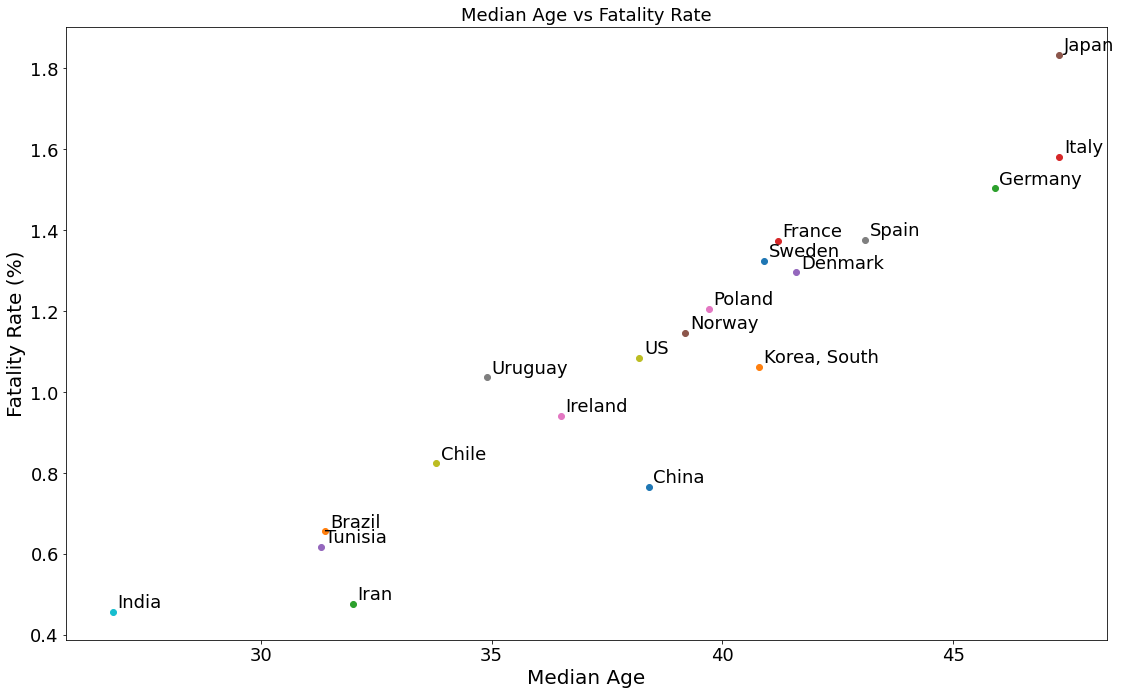

In [113]:
import matplotlib.dates as mdates

fig, (ax1) = plt.subplots(1,1,figsize=[16,10])

country_list=['China','Korea, South','Iran','Italy','Denmark','Norway','Poland','Spain','US','India',
              'Sweden','Brazil','Germany','France','Tunisia','Japan','Ireland','Uruguay','Chile']
for i in range(len(country_list)): 
    country = select_country(country_list[i])
    median_age=country['median_age']
    fatality_rate=country['fatality_rate']    
    
    ax1.plot(median_age,100*fatality_rate,'o')
    ax1.annotate(country_list[i],xy=(median_age+0.1,100*fatality_rate+0.01))
    
ax1.set_title('Median Age vs Fatality Rate')
ax1.set_ylabel('Fatality Rate (%)')
ax1.set_xlabel('Median Age')

plt.tight_layout()

#plt.show()
plt.savefig("MedianAge_FatalityRate.pdf")


In [ ]:
country = select_country('China')
plottage(country,RK3(country))

End of simulation at t = 280 days 

China
Percentage infected at peak of epidemics:  0 %
Number Symptomatic at peak of epidemics:  7062
Number Asymptomatic at peak of epidemics:  18542
Number of hospitalized at peak of epidemics:  558
Number needing ICU at peak of epidemics:  138
Number of dead: 1126.0
Number of dead: 1124.0


End of simulation at t = 280 days 

Korea, South
Percentage infected at peak of epidemics:  9 %
Number Symptomatic at peak of epidemics:  1169633
Number Asymptomatic at peak of epidemics:  4394097
Number of hospitalized at peak of epidemics:  156585
Number needing ICU at peak of epidemics:  44835
Number of dead: 435698.0
Number of dead: 435710.0


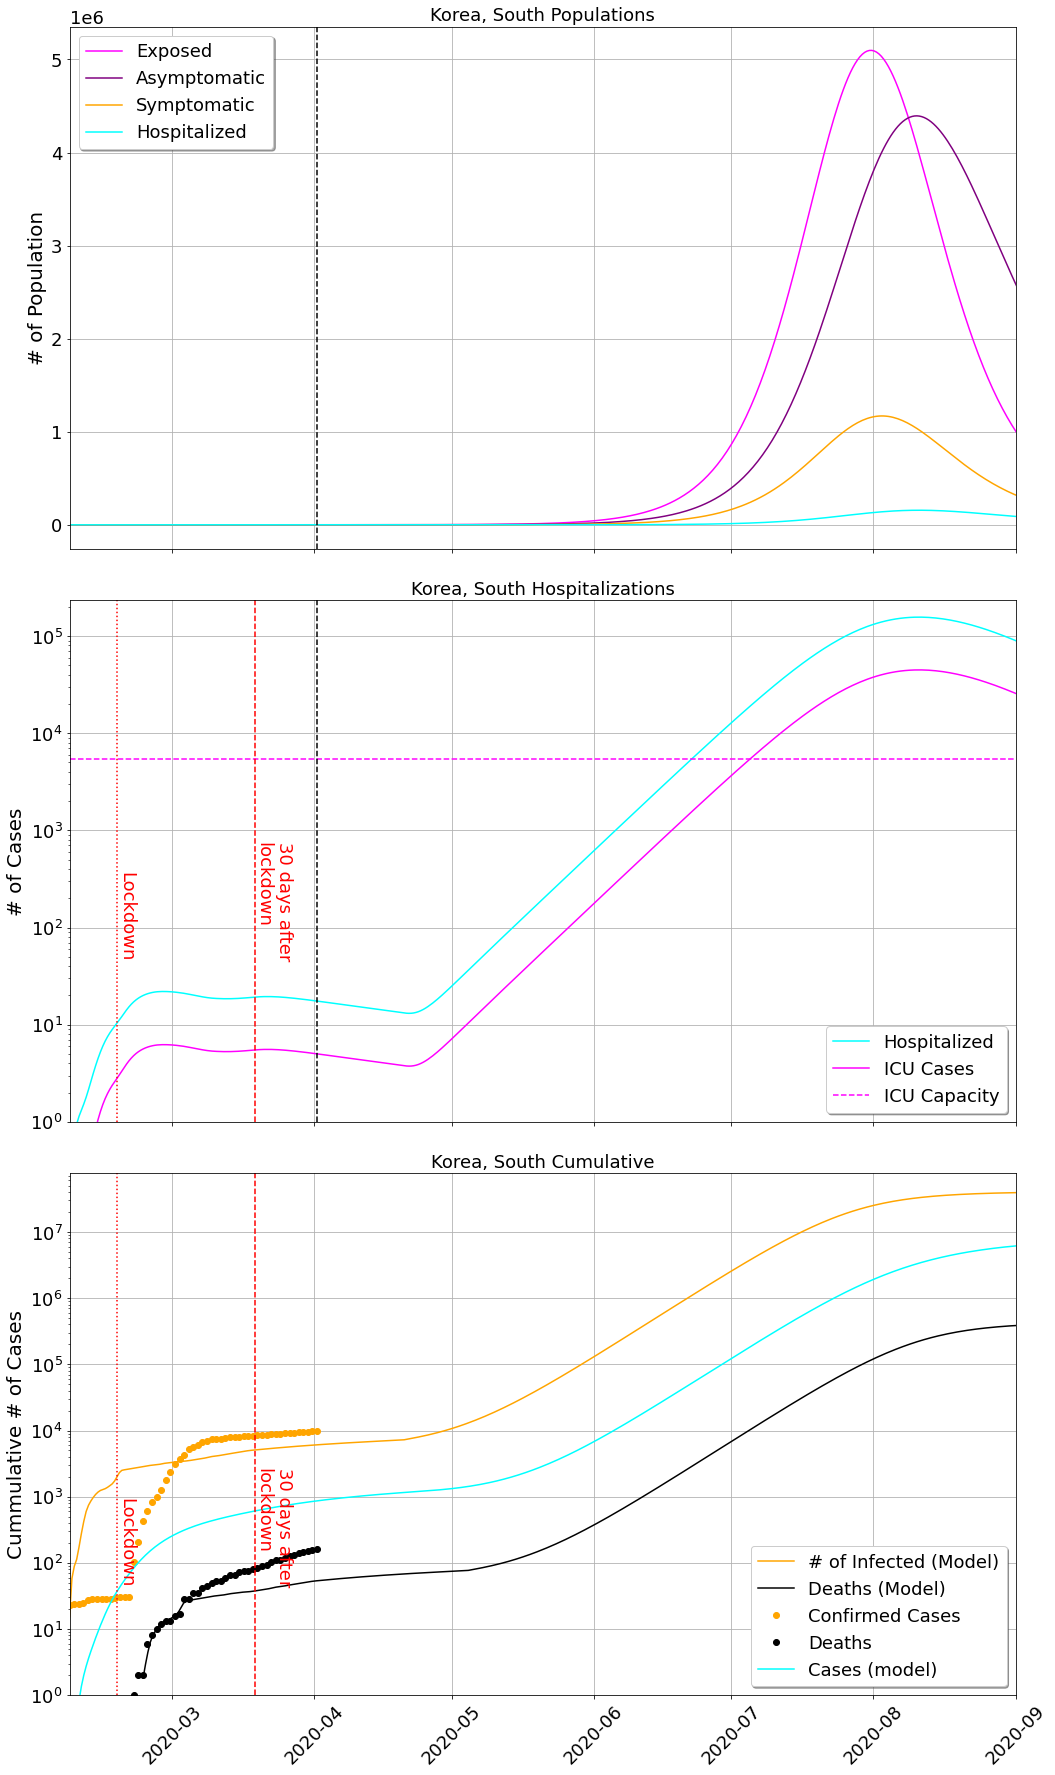

In [65]:
country = select_country('Korea, South')
plottage(country,RK3(country))


End of simulation at t = 280 days 

Italy
Percentage infected at peak of epidemics:  8 %
Number Symptomatic at peak of epidemics:  1297348
Number Asymptomatic at peak of epidemics:  4927073
Number of hospitalized at peak of epidemics:  212064
Number needing ICU at peak of epidemics:  74773
Number of dead: 761952.0
Number of dead: 761954.0


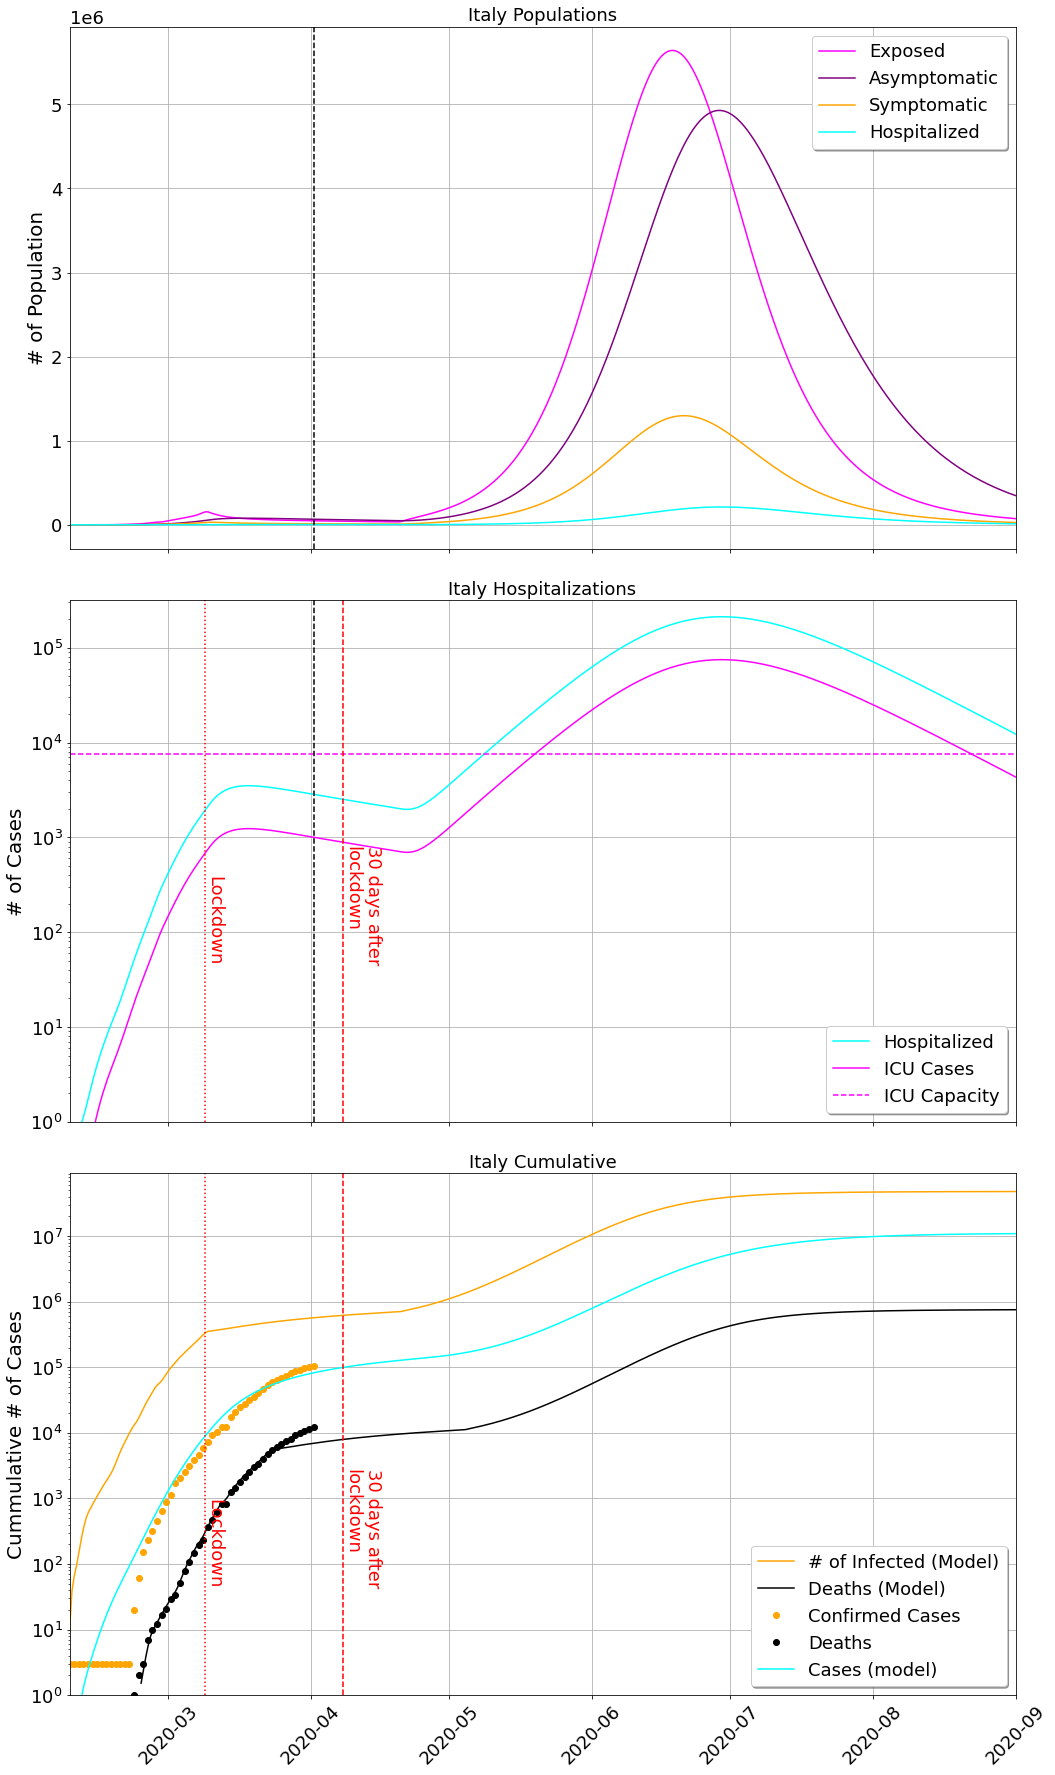

In [66]:
country = select_country('Italy')
plottage(country,RK3(country))

In [12]:
#country = select_country('Iran')
#plottage(country,RK3(country))

In [ ]:
#country = select_country('Denmark')
#plottage(country,RK3(country))

In [ ]:
##country = select_country('El Salvador')
##plottage(country,RK3(country))

In [ ]:
#country = select_country('Ireland')
#plottage(country,RK3(country))

In [ ]:
#country = select_country('Norway')
#plottage(country,RK3(country))

In [ ]:
#country = select_country('Poland')
#plottage(country,RK3(country))

In [ ]:
#country = select_country('United Kingdom')
#plottage(country,RK3(country))

In [ ]:
#country = select_country('Switzerland')
#plottage(country,RK3(country))

In [ ]:
#country = select_country('Spain')
#plottage(country,RK3(country))

In [ ]:
country = select_country('Brazil')
plottage(country,RK3(country))

In [ ]:
country = select_country('US')
plottage(country,RK3(country))

In [ ]:
country = select_country('Germany')
plottage(country,RK3(country))

End of simulation at t = 280 days 

Tunisia
Percentage infected at peak of epidemics:  8 %
Number Symptomatic at peak of epidemics:  229840
Number Asymptomatic at peak of epidemics:  888113
Number of hospitalized at peak of epidemics:  21317
Number needing ICU at peak of epidemics:  5237
Number of dead: 56518.0
Number of dead: 56521.0


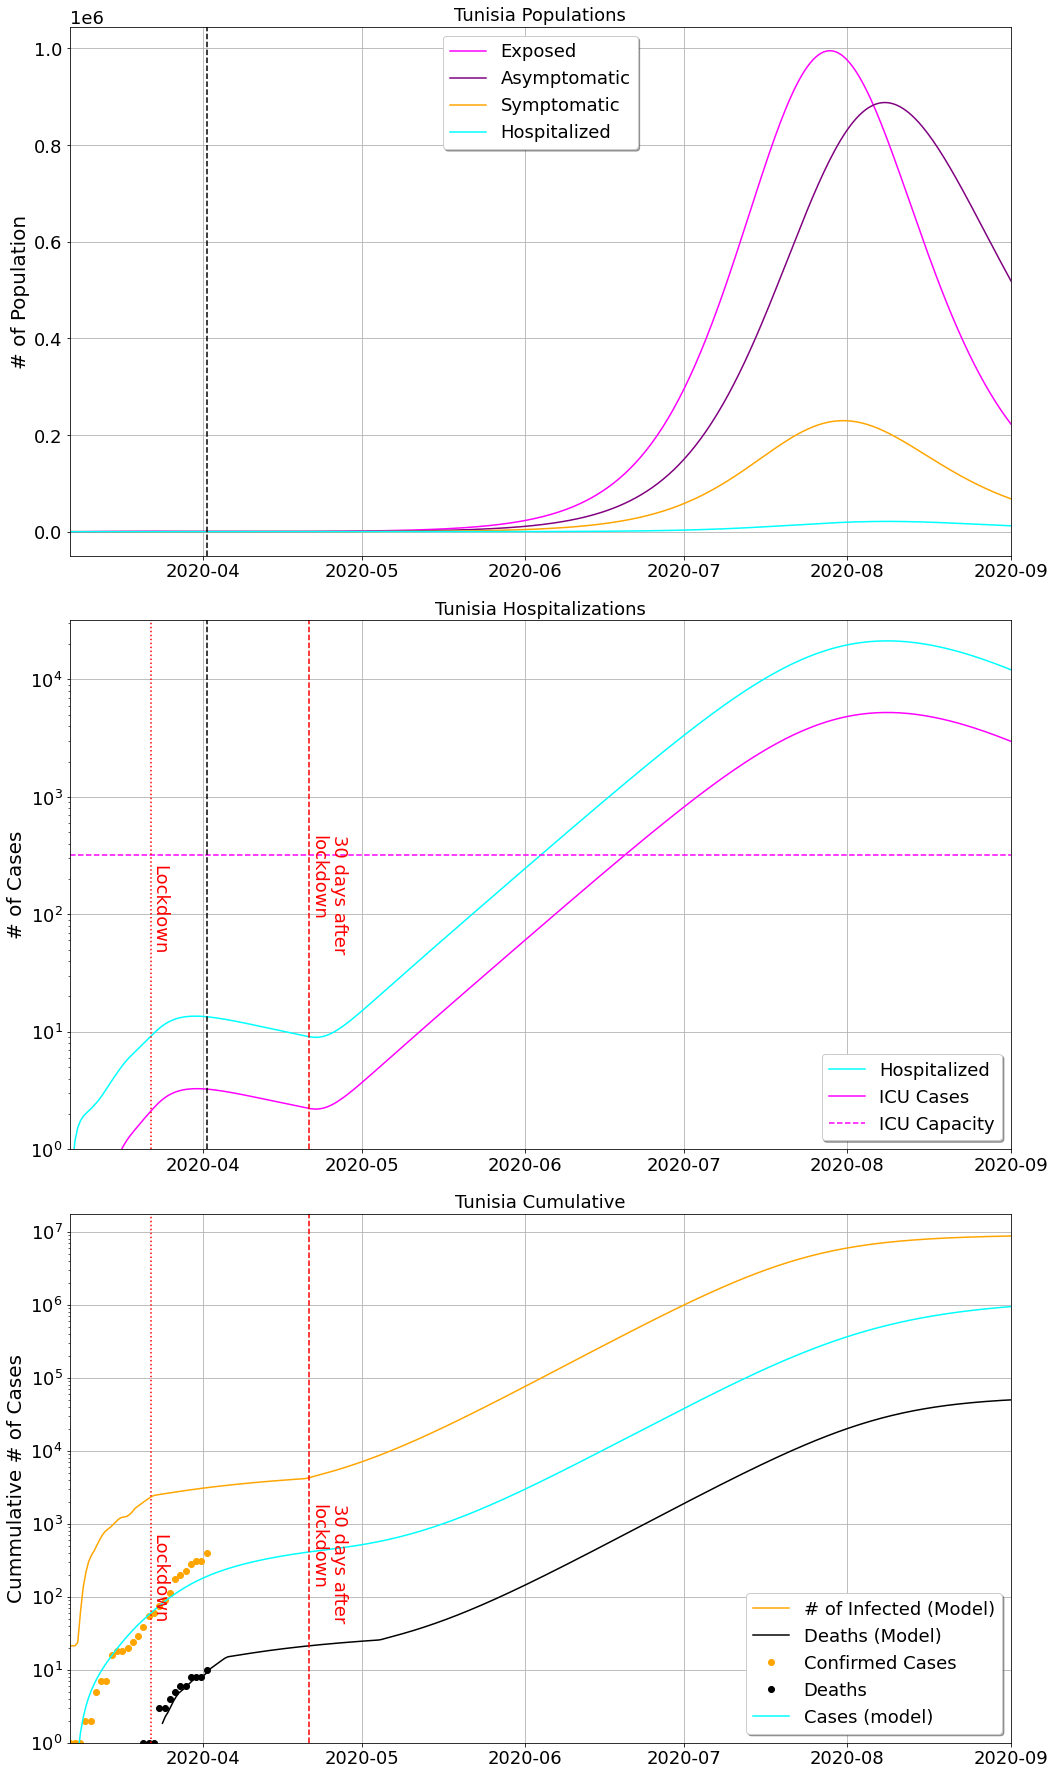

In [105]:
country = select_country('Tunisia')
plottage(country,RK3(country))

### References 

More on the model can be found here, and references therein. 

https://idpjournal.biomedcentral.com/articles/10.1186/s40249-020-00640-3

https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model

https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2
    